In [1]:
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [12,6]

import os, sys, glob
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress TF warning
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # only use GPU #
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras import losses
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.util import view_as_blocks
import io

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import tensorflow as tf

#from utils import save_batch_imgs, ray, structural_similarity
from dahuffman import HuffmanCodec


from utils import slice_image_4d, combine_image_4d
from net import build_enc_patch, build_dec_patch, UniformNoise, save_q_model, infer_q_tflite_single_local, split_k210_model

import ray
ray.init()

2021-03-04 07:42:06,898	INFO resource_spec.py:212 -- Starting Ray with 17.09 GiB memory available for workers and up to 8.56 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-03-04 07:42:07,203	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.138.0.13',
 'raylet_ip_address': '10.138.0.13',
 'redis_address': '10.138.0.13:20093',
 'object_store_address': '/tmp/ray/session_2021-03-04_07-42-06_897468_11124/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-04_07-42-06_897468_11124/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2021-03-04_07-42-06_897468_11124'}

# Experiment configs

In [2]:
# Define experiment parameters

target_list = ["MS_SSIM", "VGG_Loss", "Classification_Accuracy"]
train_target = 0
eval_target = 0

dataset_list = ["cars", "flowers", "birds", "caltech101"]
dataset_idx = 0
dataset_name = dataset_list[dataset_idx]
print("Train target: %s, eval tareget: %s, dataset: %s." % 
      (target_list[train_target], target_list[eval_target], dataset_name))

Train target: MS_SSIM, eval tareget: MS_SSIM, dataset: cars.


## Step 1. Build patch autoencoder
### 1.1 Build encoder and decoder respectively
### 1.2 Sanity check model could be compiled and converted

In [3]:
pw = 8    # pad width
input_h, input_w = 112, 112
enc_c = [64, 64, 64, 4]
dec_c = [64, 64, 64, 64]

# build encoder 
enc_patch, embed_size = build_enc_patch(Input(shape=(input_h, input_w, 3), name='enc_input'), enc_c , pw)
print(enc_patch.summary())

# build decoder
dec_patch = build_dec_patch(Input(shape=(embed_size[1]), name='dec_input'), dec_c, enc_c[-1], input_h, input_w, pw)
print(dec_patch.summary())


# build autoencoder that process a patch
nn_in = Input(shape=(input_h, input_w, 3), name='patch_input')  # adapt this if using `channels_first` image data format
x = enc_patch(nn_in)
x = UniformNoise(minval=-0.01, maxval=0.01, name='noise')(x)
# x = Dropout(0.1)(x)  ## Uncomment this line to train resilient DNN
x = dec_patch(x)
autoencoder_patch = Model(nn_in, x)

print(autoencoder_patch.summary())
print(autoencoder_patch(np.zeros((10,112,112,3))).shape)    # check model dimension

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, 112, 112, 3)]     0         
_________________________________________________________________
pad (ZeroPadding2D)          (None, 128, 128, 3)       0         
_________________________________________________________________
econv1 (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
econv2 (Conv2D)              (None, 64, 64, 64)        36928     
_________________________________________________________________
econv3 (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
econv4 (Conv2D)              (None, 16, 16, 4)         2308      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0     

In [4]:
# optional check to make sure model runs on K210. Requires TF1.15; modify line 15 accordingly !!!
check = False
if check:
    save_q_model(autoencoder_patch, "test.tflite", np.random.random((100,112,112,3)).astype(np.float32))
    !edgetpu_compiler test.tflite

    k_in = Input(batch_shape=(1, input_h, input_w, 3), name='k210_in')
    x = enc_patch(k_in)
    x = dec_patch(x)
    k210_ae = Model(k_in, x)
    # optional visualization
    tf.keras.utils.plot_model(k210_ae, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

    k210_ae.save('k210_ae_test.h5')
    !CUDA_VISIBLE_DEVICES=-1 /home/stanfordsnsg/TF1/bin/tflite_convert --enable_v1_converter --output_file k210_ae_test.tflite --keras_model_file k210_ae_test.h5
    !./K210/ncc compile k210_ae_test.tflite k210_ae_test.kmodel -i tflite -o kmodel --dataset ./Dataset/cal/ --inference-type uint8 --max-allocator-solve-secs 3

    print(os.path.getsize("k210_ae_test.kmodel"))

## Step 2. Build and train full image autoencoder
### 2.1 Build full autoencoder on top of batch autoencoder
### 2.2 Load dataset and preprocessing
### 2.3 Define loss functions
### 2.4 Train model

In [5]:
x = Input(shape=(input_h*2, input_w*2, 3), name='full_input')  # adapt this if using `channels_first` image data format
img_slices = [None]*4
img_slices[0] = tf.slice(x, [0, 0, 0, 0],             [-1, input_h, input_w, 3])
img_slices[1] = tf.slice(x, [0, 0, input_w, 0],       [-1, input_h, input_w, 3])
img_slices[2] = tf.slice(x, [0, input_h, 0, 0],       [-1, input_h, input_w, 3])
img_slices[3] = tf.slice(x, [0, input_h, input_w, 0], [-1, input_h, input_w, 3])


model_patch = [None]*4
img_outs = [None]*4
for i in range(4):
    img_outs[i] = autoencoder_patch(img_slices[i])

img_all = tf.concat([tf.concat([img_outs[0], img_outs[1]], axis=2), tf.concat([img_outs[2], img_outs[3]], axis=2)], axis=1)

autoencoder = Model(x, img_all)
print(autoencoder.summary())

# requires pydot, pydotplus, graphvis and apt-get install graphviz
#tf.keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

#plt.imshow(autoencoder(x_test[:10])[0])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
full_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Slice (TensorFlowOp [(None, 112, 112, 3) 0           full_input[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_Slice_1 (TensorFlow [(None, 112, 112, 3) 0           full_input[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_Slice_2 (TensorFlow [(None, 112, 112, 3) 0           full_input[0][0]                 
____________________________________________________________________________________________

In [6]:
dataset_fn = "./Dataset/%s_224_224_color.npy" % dataset_name
train_list = sorted( glob.glob("./Dataset/%s/split_train/*.jpg" % dataset_name) )
test_list = sorted( glob.glob("./Dataset/%s/split_test/*.jpg" % dataset_name) )

if os.path.exists(dataset_fn):
    x_train, x_test = np.load(dataset_fn, allow_pickle=True)
    print("Loaded prepared dataset: " + dataset_fn)
else:
    
    @ray.remote
    def proc_img(f):
        #  width, height in PIL
        img = Image.open(f).convert('RGB').resize((224,224), resample=Image.LANCZOS)
        return np.array(img)
    
    x_train = np.array(ray.get([proc_img.remote(x) for x in train_list]))
    x_test  = np.array(ray.get([proc_img.remote(x) for x in  test_list]))
    
    np.save(dataset_fn, [x_train, x_test])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape, x_test.shape)

Loaded prepared dataset: ./Dataset/cars_224_224_color.npy
(6516, 224, 224, 3) (1628, 224, 224, 3)


In [7]:
## Load VGG model

from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
#print(vgg16.summary())
vggs = Model(inputs=vgg16.input, outputs=vgg16.get_layer("block2_conv2").output)
#print(vggs.summary())
print(vggs(np.zeros((1,224,224,3))).shape )  # check if model works


## Load Classification model

car_model = load_model('./SavedModel/model_cars/model_0.9797.h5')
for layer in car_model.layers:
    layer.trainable = False
        
# Get labels of training and test for classification
from scipy.io import loadmat
cars_train_annos = loadmat('./Dataset/cars/devkit/cars_train_annos.mat')['annotations'][0]
cars_train_label = [c[4][0][0] - 1 for c in cars_train_annos]    # add offset 1 to make index start from 0
cars_classes = len(list(set(cars_train_label)))

train_list_label = [ cars_train_label[i-1] for i in [int(l.split('/')[-1].split('.')[0]) for l in train_list]] 
test_list_label = [ cars_train_label[i-1] for i in [int(l.split('/')[-1].split('.')[0]) for l in test_list]]
train_list_label_cat = tf.keras.utils.to_categorical(np.repeat(train_list_label, 25), cars_classes)
test_list_label_cat = tf.keras.utils.to_categorical(np.repeat(test_list_label, 25), cars_classes)


## following are assorted loss functions

def msssim_loss(y_true, y_pred):
    return tf.constant(1.0) - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 1.0))


def ssim_loss(y_true, y_pred):
    return tf.constant(1.0) - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def ssim_loss_flatten(y_true, y_pred):
    return ssim_loss(tf.reshape(y_true, [tf.shape(y_true)[0], 56, 72, 3]), y_pred)


def classification_loss_single(y_true, y_pred):
    loss = tf.keras.losses.categorical_crossentropy(car_model(y_true*2.0-1.0), car_model(y_pred*2.0-1.0))
    return tf.reduce_mean(loss, axis=-1)


def ssim_classification_loss_single(y_true, y_pred):
    ssim_loss = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    class_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(car_model(y_true*2.0-1.0), car_model(y_pred*2.0-1.0)))
    return ssim_loss + 1.1*class_loss


def input_ssim_classification_loss_single(x_true): 
    def loss_helper(y_true, y_pred):   # y_true is None
        #y_true = x_true
        return ssim_classification_loss_single(x_true, y_pred)
    return loss_helper


def ssim_classification_loss(y_true, y_pred):
    x_train = y_true[:,:56*72*3]
    train_list_label_cat = y_true[:,56*72*3:]
    return 1.0*ssim_loss_flatten(x_train, y_pred) + 0.1*classification_loss(train_list_label_cat, y_pred)


def vgg16_loss(y_true, y_pred):
    m = tf.keras.losses.MSE(vgg16(y_true*2.0-1.0), vgg16(y_pred*2.0-1.0))
    return tf.reduce_mean(tf.reduce_mean(m, -1),-1)


def input_vgg16_loss(x_true):
    def loss_helper(y_true, y_pred):   # y_true is None
        #y_true = x_true
        return vgg16_loss(x_true, y_pred)
    return loss_helper


def vggs_loss(y_true, y_pred):
    return tf.keras.losses.MSE(vggs(y_true*2.0-1.0), vggs(y_pred*2.0-1.0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(1, 112, 112, 128)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model_path = "./SavedModel/%s" % dataset_name
os.system("mkdir -p " + model_path)
best_model = model_path + "/%s_1024_99.h5" % \
             ["msssim_loss", "vgg16_loss", "classification_loss_single"][train_target]

class PredictionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        
        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1); plt.imshow(x_test[2])
        plt.subplot(1,2,2); plt.imshow(autoencoder.predict(x_test[:10])[2])
        plt.show()
        
        loss_fn = str(autoencoder.loss).split(' ')[1]
        autoencoder.save_weights(model_path + '/%s_1024_%d.h5' % (loss_fn, epoch))
        return True


autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss = [msssim_loss, vgg16_loss, classification_loss_single][train_target],
                    metrics=[msssim_loss, vgg16_loss, classification_loss_single])

if os.path.exists(best_model):
    print("Loading saved model.")
    autoencoder.load_weights(best_model)
else:
    print("Training from scratch.")
    train_gen = ImageDataGenerator(
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=15,
        width_shift_range=.15,
        height_shift_range=.15,
        horizontal_flip=True,
        vertical_flip=True) 
    train_gen.fit(x_train, augment=True)
    history = autoencoder.fit(zip(train_gen.flow(x_train, batch_size=64, seed=0), train_gen.flow(x_train, batch_size=64, seed=0)),
                        epochs=100,
                        steps_per_epoch=500,
                        #batch_size=32,
                        verbose=1,
                        shuffle=True,
                        validation_data=(x_test[:], x_test[:]),
                        #use_multiprocessing=True,
                        #workers=4,
                        callbacks=[PredictionCallback()])

Loading saved model.


0.9494081


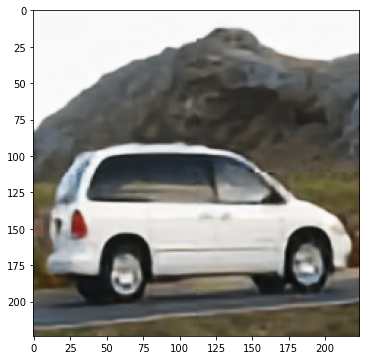

In [9]:
# Visualized trained result
r = autoencoder.predict(x_test[:100])
plt.imshow(r[2])
print(np.mean(tf.image.ssim_multiscale(x_test[:len(r)], r, 1.0)))

## Step 3. Benchmark against JPEG
### Step 3.1 Get JPEG baseline
### Step 3.2 Benchmark floating point model
### Step 3.3 Benchmark quantized model
### Step 3.4 Benchmark quantized embedding

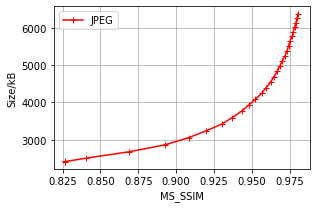

In [10]:
# benchmark on jpeg images, takes about 10 minutes to run

#@ray.remote
def jpeg_compress(img, q, file_seg):
    # input/output image in [0, 1]
    
    def get_seg_size(file_values, seg_value):
        for i in range(1, len(file_values)):
            if (file_values[i-1] == int('0xff', 16)) and (file_values[i] == seg_value):
                return len(file_values) - (i-1)
        return int(-1e8)

    tmp_file = io.BytesIO()
    Image.fromarray((img*255.0).astype(np.uint8)).save(tmp_file, 'JPEG', quality=q, subsampling=0)
    if file_seg == 0:
        size = len(tmp_file.getvalue())
    elif file_seg == 1:
        size = get_seg_size(tmp_file.getvalue(), int('0xdb', 16)) # quantization table
    elif file_seg == 2:
        size = get_seg_size(tmp_file.getvalue(), int('0xc4', 16)) # huffman table
    elif file_seg == 3:
        size = get_seg_size(tmp_file.getvalue(), int('0xda', 16)) # start of scan

    img_compress = np.array(Image.open(tmp_file))/255.0
    tmp_file.close()
    return img_compress, size


def metric_msssim(image_in, image_out):
    return tf.image.ssim_multiscale(image_in.astype('float'), image_out.astype('float'), max_val=1.0).numpy()


def metric_classification(y_true, y_pred):
    out_true = car_model(y_true*2.0-1.0)
    out_pred = car_model(y_pred*2.0-1.0)
    onehot_true = tf.one_hot(tf.argmax(out_true, axis=1), depth = out_true.shape[1])
    acc = tf.keras.metrics.top_k_categorical_accuracy(onehot_true, out_pred, k=10)
    return acc


def benchmark_jpeg(x, metric_fun, file_seg=0):
    j_size = []
    j_result = []
    
    for q in range(0,30):
        print(q, end=',')
        #r = ray.get([jpeg_compress.remote(img, q) for img in x])
        r = [jpeg_compress(img, q, file_seg) for img in x]
        j_size.append( np.array(r)[:,1] )
        
        compressed_images = np.stack( np.array(r)[:,0] )
        batch_size = 32
        tmp_result = []
        for i in range(0,len(x),batch_size):
            tmp_result += list(metric_fun(x[i:i+batch_size], compressed_images[i:i+batch_size]))
        j_result.append(np.array(tmp_result))
    
    return j_result, j_size 

metric_list = [metric_msssim, vgg16_loss, metric_classification]
metric_eval = metric_list[eval_target]

j_bench_fn = "./Output/jpeg_%s.npy" % target_list[eval_target]
if os.path.exists(j_bench_fn):
    j_qual, j_size = np.load(j_bench_fn, allow_pickle=True)
else:
    j_qual, j_size = benchmark_jpeg(x_test[:128], metric_eval)
    np.save(j_bench_fn, [j_qual, j_size])

plt.figure(figsize=(4.5,3))
plt.plot( np.mean(j_qual, axis=1), np.mean(j_size, axis=1), '-r+', label='JPEG' )
plt.xlabel(target_list[eval_target]);plt.ylabel("Size/kB");plt.grid();plt.tight_layout();plt.legend()

0.9507258


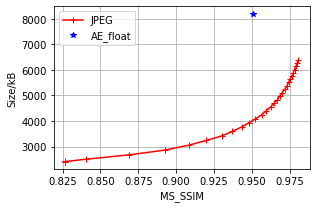

In [11]:
# Optional visualization code
#import keract
#keract.__version__
#activations = keract.get_activations(autoencoder, x_test[2][np.newaxis,:,:,:].astype('float64'))
#activations = keract.get_activations(enc_patch, x_test[2][np.newaxis,:112,:112,:])
#keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last')

## !!! important parameter, adjust according to your GPU memory size
x_test_len = 64

ae_float_out = autoencoder.predict(x_test[:x_test_len], batch_size=32)
ae_float_result = metric_eval(x_test[:len(ae_float_out)], ae_float_out)

print(np.mean(ae_float_result))

plt.figure(figsize=(4.5,3))
plt.plot( np.mean(j_qual, axis=1), np.mean(j_size, axis=1), '-r+', label='JPEG' )
plt.plot(np.mean(ae_float_result), embed_size[1]*2*4, 'b*', label='AE_float')  # assuming float16 for embedding -> 2Bytes, 4 patches
plt.xlabel(target_list[eval_target]);plt.ylabel("Size/kB");plt.grid();plt.tight_layout();plt.legend()

Saved quantized tflite model ./Output/enc_patch.tflite
Finished infer.


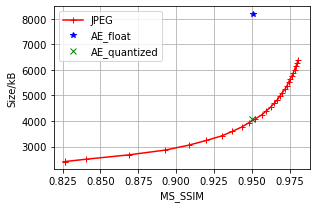

In [12]:
@ray.remote
def infer_q_tflite_single(fn, s):
    import tensorflow as tf
    interpreter = tf.compat.v1.lite.Interpreter(fn)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], s)
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])

    
def infer_q_tflite_batch(fn, s):
    return np.array(ray.get([infer_q_tflite_single.remote(fn, s[i][np.newaxis, :, :, :]) for i in range(len(s))]))


save_q_model(enc_patch, "./Output/enc_patch.tflite", x_test[:,:112,:112,:])
patch_enc_quantized_out = [None]*4
patch_dec_quantized_out = [None]*4
for i in range(4):
    tmp_test = slice_image_4d(x_test[:x_test_len], i)
    patch_enc_quantized_out[i] = infer_q_tflite_batch("./Output/enc_patch.tflite", tmp_test)
    patch_dec_quantized_out[i] = dec_patch(patch_enc_quantized_out[i][:,0,:])
print("Finished infer.")

ae_quantized_out = combine_image_4d(patch_dec_quantized_out)
ae_quantized_result = metric_eval(x_test[:len(ae_quantized_out)], ae_quantized_out)

plt.figure(figsize=(4.5,3))
plt.plot( np.mean(j_qual, axis=1), np.mean(j_size, axis=1), '-r+', label='JPEG' )
plt.plot(np.mean(ae_float_result), embed_size[1]*2*4, 'b*', label='AE_float')  # assuming float16 for embedding -> 2Bytes, 4 patches
plt.plot(np.mean(ae_quantized_result), embed_size[1]*1*4, 'gx', label='AE_quantized')  # int8 for embedding -> 1Byte, 4 patches
plt.xlabel(target_list[eval_target]);plt.ylabel("Size/kB");plt.grid();plt.tight_layout();plt.legend()

256 0.9499234 3330.046875
192 0.9498386 3273.265625
128 0.9495584 3024.609375
96 0.9491247 2843.203125
64 0.94797844 2568.15625
48 0.9464011 2366.703125
32 0.94164 2078.765625
24 0.9350937 1873.71875
16 0.91786546 1580.484375
12 0.8956504 1374.046875
8 0.84440696 1085.8125


No handles with labels found to put in legend.


6 0.78745186 899.734375


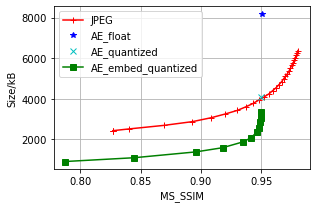

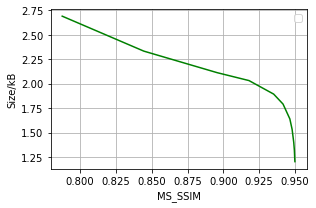

In [13]:
## Then run TFLite inference and quantize embedding
def quantize(d, Q_level):
    d_min, d_max = np.min(d), np.max(d)
    q = np.digitize(d, np.linspace(d_min, d_max, Q_level), right=True)
    s = d_max - d_min
    z = d_min
    return q, s, z, Q_level


def de_quantize(q, s, z, Q_level):
    d = [e/Q_level*s+z for e in q]
    return np.array(d)


#@ray.remote
def quantize_embedding(embed, Q_level):
    ## Data flow:   embed -> quantize -> huffman encode -> huffman decode -> de_quantize
    enc_q, s, z, _ = quantize(embed, Q_level)
    
    # huffman doesn't work well for low bits quantization
    from dahuffman import HuffmanCodec
    codec = HuffmanCodec.from_data([str(e) for e in enc_q])
    enc_huff = codec.encode([str(e) for e in enc_q])
    enc_huff_dec = [ int(x) for x in codec.decode(enc_huff)]
    #print("Compression size before/after and error:", len(embed), len(enc_huff), np.sum(np.abs(enc_huff_dec - enc_q)))

    enc_q_dq = de_quantize(enc_huff_dec, s, z, Q_level).reshape(embed.shape)
    #print("Mean quantization error and mean embed value:", np.mean(np.abs(embed - enc_q_dq)), np.mean(np.abs(embed)))
    return enc_q_dq, len(enc_huff)


tfl_embed_quant_result = []
tfl_embed_quant_size = []
output_images = []
for Q_level in [256, 192, 128, 96, 64, 48, 32, 24, 16, 12, 8, 6]:
    embed_quantized = [None]*4
    embed_quantized_size = [None]*4  
    patch_dec_quantized_out = [None]*4

    for i in range(4):
        r = [quantize_embedding(embed[0], Q_level) for embed in patch_enc_quantized_out[i]]
        embed_quantized[i] = np.array([e[0] for e in r]).astype(np.float32)
        embed_quantized_size[i] = np.array([e[1] for e in r])
        patch_dec_quantized_out[i] = dec_patch(embed_quantized[i])
    
    tfl_quantized = combine_image_4d(patch_dec_quantized_out)
    output_images.append(tfl_quantized)

    embed_quantized_result = metric_eval(x_test[:len(tfl_quantized)], tfl_quantized)
    tfl_embed_quant_result.append(np.mean(embed_quantized_result))
    tfl_embed_quant_size.append(np.sum(embed_quantized_size, axis=0)[:len(tfl_quantized)].mean())
    print(Q_level, tfl_embed_quant_result[-1], tfl_embed_quant_size[-1])
    
plt.figure(figsize=(4.5,3))
plt.plot(np.mean(j_qual, axis=1), np.mean(j_size, axis=1), '-r+', label='JPEG' )
plt.plot(np.mean(ae_float_result), embed_size[1]*2*4, 'b*', label='AE_float')  # assuming float16 for embedding -> 2Bytes, 4 patches
plt.plot(np.mean(ae_quantized_result), embed_size[1]*1*4, 'cx', label='AE_quantized')  # int8 for embedding -> 1Byte, 4 patches
plt.plot(tfl_embed_quant_result, tfl_embed_quant_size, '-gs', label='AE_embed_quantized')
plt.xlabel(target_list[eval_target]);plt.ylabel("Size/kB");plt.grid();plt.tight_layout();plt.legend()

# size ratio plot
plt.figure(figsize=(4.5, 3))
ratio = np.interp(np.array(tfl_embed_quant_result), np.mean(j_qual, axis=1).astype(np.float32), np.mean(j_size, axis=1).astype(np.float32)) / np.array(tfl_embed_quant_size)
plt.plot(tfl_embed_quant_result, ratio,'-g')
plt.xlabel(target_list[eval_target]);plt.ylabel("Size/kB");plt.grid();plt.tight_layout();plt.legend()

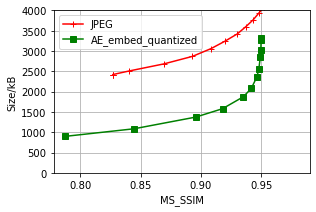

In [14]:
plt.figure(figsize=(4.5,3))
plt.plot(np.mean(j_qual, axis=1), np.mean(j_size, axis=1), '-r+', label='JPEG' )
if eval_target==2:
    range_idx = 6 # clamp index for classification
else:
    range_idx = 0
plt.plot(tfl_embed_quant_result[range_idx:], tfl_embed_quant_size[range_idx:], '-gs', label='AE_embed_quantized')
plt.xlabel(target_list[eval_target]);plt.ylabel("Size/kB");plt.grid();plt.tight_layout();plt.legend()
plt.ylim([0, 4000])
if eval_target==1: 
    plt.gca().invert_xaxis() # reverse axis for VGG
plt.savefig("./Output/%s_%s.pdf" % (dataset_name, target_list[eval_target]) )


result_all = {}
result_all['ae_quantized_out'] = ae_quantized_out
result_all['output_images'] = output_images
result_all['jpeg_x'] = np.mean(j_qual, axis=1) 
result_all['jpeg_y'] = np.mean(j_size, axis=1)
result_all['x'] = tfl_embed_quant_result
result_all['y'] = tfl_embed_quant_size
result_all['ratio'] = ratio
result_all['AE_float'] = [np.mean(ae_float_result), embed_size[1]*4*4]
result_all['AE_quantized'] = [np.mean(ae_quantized_result), embed_size[1]*1*4]

out_dir = "./Output/rd_result/"
os.system("mkdir -p " + out_dir)
np.save(out_dir + "%s_%s.npy" % (dataset_name, target_list[eval_target]), result_all)